# Object Detection with YOLOv3 in Tensorflow
> Learn how to build YOLOv3 in Tensorflow and use pre-trained weights to quickly perform Object Detection

- toc: true
- badges: true
- comments: true
- author: dzlab
- categories: [tensorflow, vision, object-detection]

[YOLO](https://pjreddie.com/darknet/yolo/) (You Only Look Once) is an end to end object detection algorithm. Compared to other algorithms that repurpose classifiers to perform detection, YOLO requires only a single pass to detect objects, i.e. classes probabilities and bounding boxes.

It works by dividing an image into `N` equaly sized `SxS` regions. Each grid will predict the probability of object presence, the coordinates of a bounding box `B` and the object label. This makes YOLO a very fast algorithm and can be used for real time detection.

In this article, we will build YOLO v3 in Tensorflow and initiate its weights with the weights of the original YOLO v3 model pretrained on the COCO dataset. The following diagram illustrates the architecture of YOLO we will be building.

![YOLO architecture](https://assets-global.website-files.com/5d7b77b063a9066d83e1209c/60edcdbac45c393745a38866_Laxtd5ZwPSu4Dk33rVzIFt4tEDXwv03HzUU6SD5XvEFxb7BRoQdg7Qm32xEiUjJqJRNHA3mgmj7vZCPcuoWnRX-u7ULiQtsdPKzW61lq5D-UJ4O82S6bOc5ZPT4f5MMRk62c3vt2.png)

> Our implementation is heavily inspired by this Keras implementation - [repo](https://github.com/experiencor/keras-yolo3)


First, let's download the weights from the YOLO website, as well as the labels of the COCO dataset

In [ ]:
%%capture
%%bash

curl -s -O https://pjreddie.com/media/files/yolov3.weights
curl -o coco_labels.txt https://raw.githubusercontent.com/amikelive/coco-labels/master/coco-labels-2014_2017.txt
echo "[[116, 90, 156, 198, 373, 326], [30, 61, 62, 45, 59, 119], [10, 13, 16, 30, 33, 23]]" > anchors.json

Declare all the imports we will be needed

In [ ]:
import glob
import json
import struct
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.patches import Rectangle
import tensorflow as tf
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
from tensorflow.keras.preprocessing.image import *

%matplotlib inline

Second, we define a class to initialize the weight of a YOLO network, it will read the weights file and set the weight of every layer in the model's 106 layers.

In [ ]:
class ModelInitializer:
    def __init__(self, weight_file):
        self.offset = 0
        self.all_weights = self._load_weights(weight_file)

    def _load_weights(self, weight_file):
        with open(weight_file, 'rb') as w_f:
            major, = struct.unpack('i', w_f.read(4))
            minor, = struct.unpack('i', w_f.read(4))
            revision, = struct.unpack('i', w_f.read(4))
            if (major * 10 + minor) >= 2 and major < 1000 and minor < 1000:
                w_f.read(8)
            else:
                w_f.read(4)
            binary = w_f.read()
        return np.frombuffer(binary, dtype='float32')

    def read_bytes(self, size):
        """return number of bytes from the weights file"""
        self.offset = self.offset + size
        return self.all_weights[self.offset-size:self.offset]

    def init_layer_weights(self, model, i):
        """Initialize the weight of a sepecific layer by its index"""
        conv_layer = model.get_layer(f'conv_{i}')
        if i not in [81, 93, 105]:
            norm_layer = model.get_layer(f'bnorm_{i}')
            size = np.prod(norm_layer.get_weights()[0].shape)
            bias = self.read_bytes(size)
            scale = self.read_bytes(size)
            mean = self.read_bytes(size)
            var = self.read_bytes(size)
            norm_layer.set_weights([scale, bias, mean, var])
        if len(conv_layer.get_weights()) > 1:
            bias = self.read_bytes(np.prod(conv_layer.get_weights()[1].shape))
            kernel = self.read_bytes(np.prod(conv_layer.get_weights()[0].shape))
            kernel = kernel.reshape(list(reversed(conv_layer.get_weights()[0].shape)))
            kernel = kernel.transpose([2, 3, 1, 0])
            conv_layer.set_weights([kernel, bias])
        else:
            kernel = self.read_bytes(np.prod(conv_layer.get_weights()[0].shape))
            kernel = kernel.reshape(list(reversed(conv_layer.get_weights()[0].shape)))
            kernel = kernel.transpose([2, 3, 1, 0])
            conv_layer.set_weights([kernel])

    def init_weights(self, model):
        """Load the weights of each of the model 106 layers"""
        for i in range(106):
            try:
                self.init_layer_weights(model, i)
            except ValueError:
                pass

    def reset(self):
        self.offset = 0


To make our life easy when dealing with the coordinates and any information about the detected onject, we group those metadata information into a class

In [ ]:
class BoundBox(object):
    def __init__(self, x_min, y_min, x_max, y_max, objness=None, classes=None):
        self.xmin = x_min
        self.ymin = y_min
        self.xmax = x_max
        self.ymax = y_max
        self.objness = objness
        self.classes = classes
        self.label = -1
        self.score = -1

    def get_label(self):
        if self.label == -1:
            self.label = np.argmax(self.classes)
        return self.label

    def get_score(self):
        if self.score == -1:
            self.score = self.classes[self.get_label()]
        return self.score

Next, we define some some utility functions that work on the bounding boxes:
- `calculate_interval_overlap` to perform Non Maximal Suppression or shorly NMS (for more details see [link](https://www.coursera.org/lecture/convolutional-neural-networks/non-max-suppression-dvrjH)) and reduce detections of same object multiple times.
- `calculate_bbox_iou` to calculate the value of Intersection Over Union or shorly IoU (for more details see [link](https://en.wikipedia.org/wiki/Jaccard_index)) between two bounding boxes


In [ ]:
def calculate_interval_overlap(interval_a, interval_b):
    x1, x2 = interval_a
    x3, x4 = interval_b

    if x3 < x1:
        if x4 < x1:
            return 0
        else:
            return min(x2, x4) - x1
    else:
        if x2 < x3:
            return 0
        else:
            return min(x2, x4) - x3

def calculate_bbox_iou(box1, box2):
    intersect_w = calculate_interval_overlap([box1.xmin, box1.xmax], [box2.xmin, box2.xmax])
    intersect_h = calculate_interval_overlap([box1.ymin, box1.ymax], [box2.ymin, box2.ymax])

    intersect = intersect_w * intersect_h

    w1, h1 = box1.xmax - box1.xmin, box1.ymax - box1.ymin
    w2, h2 = box2.xmax - box2.xmin, box2.ymax - box2.ymin

    union = w1 * h1 + w2 * h2 - intersect
    return float(intersect) / union


Next, we define a helper function to create a YOLO convolutional block, add batch normalization, leaky ReLU activations, and optionally use a skip connection.


In [ ]:
def create_conv_block(input, convolutions, skip=True):
    x = input
    count = 0
    for conv in convolutions:
        if count == (len(convolutions) - 2) and skip:
            skip_connection = x
        count += 1
        if conv['stride'] > 1:
            x = ZeroPadding2D(((1, 0), (1, 0)))(x)

        x = Conv2D(
            conv['filter'],
            conv['kernel'],
            strides=conv['stride'],
            padding=('valid' if conv['stride'] > 1 else 'same'),
            name=f'conv_{conv["layer_idx"]}',
            use_bias=(False if conv['bnorm'] else True)
            )(x)
        if conv['bnorm']:
            name = f'bnorm_{conv["layer_idx"]}'
            x = BatchNormalization(epsilon=1e-3, name=name)(x)
        if conv['leaky']:
            name = f'leaky_{conv["layer_idx"]}'
            x = LeakyReLU(alpha=0.1, name=name)(x)
    return Add()([skip_connection, x]) if skip else x


Next, we define a helper function to create the actual architecture of the YOLO model and all of its 106 layers using the previously defined helper function to create individual blocks.

In [ ]:
def create_architecture():
    input_image = Input(shape=(None, None, 3))

    # Layer  0 => 4
    x = create_conv_block(input_image, [
        {'filter': 32, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 0},
        {'filter': 64, 'kernel': 3, 'stride': 2, 'bnorm': True, 'leaky': True, 'layer_idx': 1},
        {'filter': 32, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 2},
        {'filter': 64, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 3}
        ])

    # Layer  5 => 8
    x = create_conv_block(x, [
        {'filter': 128, 'kernel': 3, 'stride': 2, 'bnorm': True, 'leaky': True, 'layer_idx': 5},
        {'filter': 64, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 6},
        {'filter': 128, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 7}
        ])

    # Layer  9 => 11
    x = create_conv_block(x, [
        {'filter': 64, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 9},
        {'filter': 128, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 10}
        ])

    # Layer 12 => 15
    x = create_conv_block(x, [
        {'filter': 256, 'kernel': 3, 'stride': 2, 'bnorm': True, 'leaky': True, 'layer_idx': 12},
        {'filter': 128, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 13},
        {'filter': 256, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 14}
        ])

    # Layer 16 => 36
    for i in range(7):
        x = create_conv_block(x, [
            {'filter': 128, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 16 + i * 3},
            {'filter': 256, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 17 + i * 3}
            ])
    skip_36 = x

    # Layer 37 => 40
    x = create_conv_block(x, [
        {'filter': 512, 'kernel': 3, 'stride': 2, 'bnorm': True, 'leaky': True, 'layer_idx': 37},
        {'filter': 256, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 38},
        {'filter': 512, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 39}
        ])

    # Layer 41 => 61
    for i in range(7):
        x = create_conv_block(x, [
            {'filter': 256, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 41 + i * 3},
            {'filter': 512, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 42 + i * 3}
            ])
    skip_61 = x

    # Layer 62 => 65
    x = create_conv_block(x, [
        {'filter': 1024, 'kernel': 3, 'stride': 2, 'bnorm': True, 'leaky': True, 'layer_idx': 62},
        {'filter': 512, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 63},
        {'filter': 1024, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 64}
        ])

    # Layer 66 => 74
    for i in range(3):
        x = create_conv_block(x, [
            {'filter': 512, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 66 + i * 3},
            {'filter': 1024, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 67 + i * 3}
            ])

    # Layer 75 => 79
    x = create_conv_block(x, [
        {'filter': 512, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 75},
        {'filter': 1024, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 76},
        {'filter': 512, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 77},
        {'filter': 1024, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 78},
        {'filter': 512, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 79}
        ], skip=False)

    # Layer 80 => 82
    yolo_82 = create_conv_block(x, [
        {'filter': 1024, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 80},
        {'filter': 255, 'kernel': 1, 'stride': 1, 'bnorm': False, 'leaky': False, 'layer_idx': 81}
        ], skip=False)

    # Layer 83 => 86
    x = create_conv_block(x, [
        {'filter': 256, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 84}], skip=False)
    x = UpSampling2D(2)(x)
    x = Concatenate()([x, skip_61])

    # Layer 87 => 91
    x = create_conv_block(x, [
        {'filter': 256, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 87},
        {'filter': 512, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 88},
        {'filter': 256, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 89},
        {'filter': 512, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 90},
        {'filter': 256, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 91}
        ], skip=False)
    # Layer 92 => 94
    yolo_94 = create_conv_block(x, [
        {'filter': 512, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 92},
        {'filter': 255, 'kernel': 1, 'stride': 1, 'bnorm': False, 'leaky': False, 'layer_idx': 93}
        ], skip=False)

    # Layer 95 => 98
    x = create_conv_block(x, [
        {'filter': 128, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 96}], skip=False)
    x = UpSampling2D(2)(x)
    x = Concatenate()([x, skip_36])

    # Layer 99 => 106
    yolo_106 = create_conv_block(x, [
        {'filter': 128, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 99},
        {'filter': 256, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 100},
        {'filter': 128, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 101},
        {'filter': 256, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 102},
        {'filter': 128, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 103},
        {'filter': 256, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 104},
        {'filter': 255, 'kernel': 1, 'stride': 1, 'bnorm': False, 'leaky': False, 'layer_idx': 105}
        ], skip=False)

    return Model(inputs=input_image, outputs=[yolo_82, yolo_94, yolo_106])

Now, we can finalize the model creation and load its weight. We put all this into the following function:

In [ ]:
def create_model(weights_path):
    model = create_architecture()
    initializer = ModelInitializer(weights_path)
    initializer.init_weights(model)
    model.save('model.h5')
    model = load_model('model.h5')
    return model

Next, we define some utility functions to read the COCO labels and YOLO anchors files.
> The YOLO bounding boxes are defined in the context of anchor boxes chosen by the original authors based on the size of objects in the COCO dataset.

In [ ]:
def get_labels(path):
    labels = []
    with open(path, 'r') as f:
        for l in f:
            labels.append(l.strip())
    return labels

def get_anchors(path):
    with open(path, 'r') as f:
        return json.load(f)

Next, we define a helper class that will be used to wrap the YOLO model and provide an easy way to run inference and return detected objects with their bounding boxes.

In [ ]:
class YOLOv3(object):
    def __init__(self, model, labels, anchors, class_threshold=0.65):
        self.model = model
        self.labels = labels
        self.anchors = anchors
        self.class_threshold = class_threshold

    @staticmethod
    def _sigmoid(x):
        """return the Sigmoid value of a tensor"""
        return 1.0 / (1.0 + np.exp(-x))

    def _decode_output(self, network_output, anchors, obj_thresh, network_height, network_width):
        """Decode the output of YOLO candidate bounding boxes and class predictions"""
        grid_height, grid_width = network_output.shape[:2]
        nb_box = 3
        network_output = network_output.reshape((grid_height, grid_width, nb_box, -1))

        boxes = []
        network_output[..., :2] = self._sigmoid(network_output[..., :2])
        network_output[..., 4:] = self._sigmoid(network_output[..., 4:])
        network_output[..., 5:] = (network_output[..., 4][..., np.newaxis] * network_output[..., 5:])
        network_output[..., 5:] *= network_output[..., 5:] > obj_thresh

        for i in range(grid_height * grid_width):
            r = i / grid_width
            c = i % grid_width

            for b in range(nb_box):
                objectness = network_output[int(r)][int(c)][b][4]

                if objectness.all() <= obj_thresh:
                    # skip bounding boxes as confidence of object presence is low
                    continue
                x, y, w, h = network_output[int(r)][int(c)][b][:4]
                x = (c + x) / grid_width
                y = (r + y) / grid_height
                w = (anchors[2 * b] * np.exp(w) / network_width)
                h = (anchors[2 * b + 1] * np.exp(h) / network_height)

                classes = network_output[int(r)][c][b][5:]
                box = BoundBox(x - w / 2, y - h / 2, x + w / 2, y + h / 2, objectness, classes)
                boxes.append(box)

        return boxes

    @staticmethod
    def _correct_yolo_boxes(boxes, image_height, image_width, network_height, network_width):
        """Rescale the bounding boxes to the dimensions of the original image"""
        new_w, new_h = network_width, network_height

        for i in range(len(boxes)):
            x_offset = (network_width - new_w) / 2.0
            x_offset /= network_width
            x_scale = float(new_w) / network_width

            y_offset = (network_height - new_h) / 2.0
            y_offset /= network_height
            y_scale = float(new_h) / network_height

            boxes[i].xmin = int((boxes[i].xmin - x_offset) / x_scale * image_width)
            boxes[i].xmax = int((boxes[i].xmax - x_offset) / x_scale * image_width)
            boxes[i].ymin = int((boxes[i].ymin - y_offset) / y_scale * image_height)
            boxes[i].ymax = int((boxes[i].ymax - y_offset) / y_scale * image_height)

    def _non_max_suppression(self, boxes, nms_thresh):
        """Minimize number of duplicates bounding boxes by apply NMS"""
        if len(boxes) > 0:
            nb_class = len(boxes[0].classes)
        else:
            return

        for c in range(nb_class):
            sorted_indices = np.argsort([-box.classes[c] for box in boxes])

            for i in range(len(sorted_indices)):
                index_i = sorted_indices[i]

                if boxes[index_i].classes[c] == 0:
                    continue

                for j in range(i + 1, len(sorted_indices)):
                    index_j = sorted_indices[j]
                    iou = calculate_bbox_iou(boxes[index_i], boxes[index_j])
                    if iou >= nms_thresh:
                        boxes[index_j].classes[c] = 0

    def _get_boxes(self, boxes):
        """Select bounding boxes containing object with confidence above threshold"""
        v_boxes, v_labels, v_scores = [], [], []

        for box in boxes:
            for i in range(len(self.labels)):
                if box.classes[i] > self.class_threshold:
                    v_boxes.append(box)
                    v_labels.append(self.labels[i])
                    v_scores.append(box.classes[i] * 100)

        return v_boxes, v_labels, v_scores

    def predict(self, image, width, height):
        """Return detected bounding boxes detected by YOLO and applies NMS to remove redundant detections"""
        image = np.expand_dims(image, axis=0)
        preds = self.model.predict(image)
        boxes = []
        for i in range(len(preds)):
            # decodes the outputs of the network
            box = self._decode_output(preds[i][0], self.anchors[i], self.class_threshold, 416, 416)
            boxes.extend(box)
        # corrects the boxes so that they have proper proportions in relation to the input image
        self._correct_yolo_boxes(boxes, height, width, 416, 416)
        self._non_max_suppression(boxes, .5)
        # select valid bounding boxes
        valid_boxes, valid_labels, valid_scores = self._get_boxes(boxes)

        return valid_boxes, valid_labels, valid_scores

We also need a function to plot the predictions: bounding boxes and detection object label, as well as confidence score.


In [ ]:
def draw_image_with_boxes(ax, data, v_boxes, v_labels, v_scores):
    ax.imshow(data)
    ax.axis('off')

    for i in range(len(v_boxes)):
        box = v_boxes[i]
        width = box.xmax - box.xmin
        height = box.ymax - box.ymin
        rectangle = Rectangle((box.xmin, box.ymin), width, height, fill=False, color='yellow')
        ax.add_patch(rectangle)
        label = f'{v_labels[i]} ({v_scores[i]:.2f})'
        ax.text(box.xmin, box.ymin, label, color='yellow')

Now, we can finally create a YOLO v3 model architecture and initialize its weight
> Note: you can use `tf.keras.utils.plot_model(yolo)` to plot the model.

In [ ]:
labels = get_labels('coco_labels.txt')
anchors = get_anchors('anchors.json')
network = create_model('yolov3.weights')
model = YOLOv3(network, labels, anchors)

To test the model, let's download some images (you can use yours)

In [ ]:
%%bash
mkdir -p images
curl -s -o images/bicycle1.jpg https://cdn.pixabay.com/photo/2016/11/30/12/29/bicycle-1872682_960_720.jpg
curl -s -o images/bicycle2.jpg https://cdn.pixabay.com/photo/2016/11/22/23/49/cyclists-1851269_960_720.jpg
curl -s -o images/animal1.jpg https://cdn.pixabay.com/photo/2014/05/20/21/20/bird-349026_960_720.jpg
curl -s -o images/animal2.jpg https://cdn.pixabay.com/photo/2018/05/27/18/19/sparrows-3434123_960_720.jpg
curl -s -o images/car1.jpg https://cdn.pixabay.com/photo/2016/02/13/13/11/oldtimer-1197800_960_720.jpg
curl -s -o images/car2.jpg https://cdn.pixabay.com/photo/2016/09/11/10/02/renault-juvaquatre-1661009_960_720.jpg

Finally, run the model on each image and draw it to confirm the detections

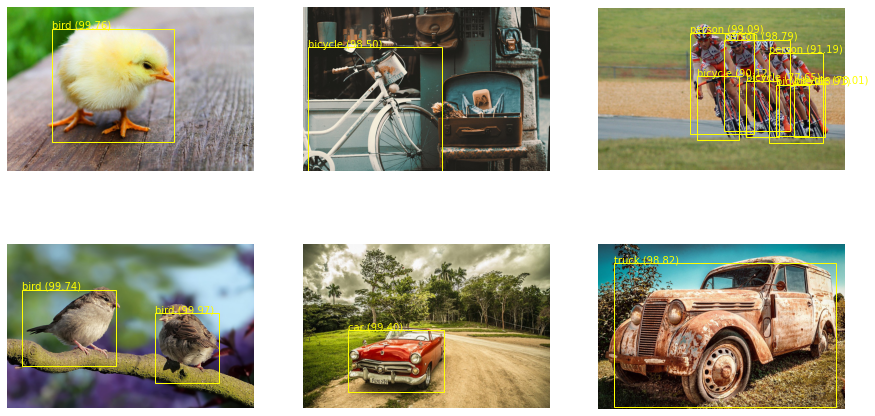

In [ ]:
figure, axis = plt.subplots(2, 3, figsize=(15, 8))
for index, image_path in enumerate(glob.glob('images/*.jpg')):
    image = load_img(image_path, target_size=(416, 416))
    image = img_to_array(image)
    image = image.astype('float32') / 255.0
    original_image = load_img(image_path)
    width, height = original_image.size
    boxes, labels, scores = model.predict(image, width, height)
    row, col = int(index / 3), index % 3
    draw_image_with_boxes(axis[row, col], original_image, boxes, labels, scores)

You can see that the model is able to acurrately detect the object and their bounding boxes.

> To learn more about the YOLO algorithm I encourage you to read the original paper - [link](https://arxiv.org/abs/1506.02640)